In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

import joblib
from time import time

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

#### Data load & Preview

In [2]:
df = pd.read_csv("iris.csv")
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


The data has no null values and all the columns are in the correct data types. 

In [4]:
df.describe()

,sepal.length,sepal.width,petal.length,petal.width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
df.variety.value_counts()

Setosa        50
Versicolor    50
Virginica     50
Name: variety, dtype: int64

The target column is balanced, with 50 rows each for three target values.

#### EDA

In [6]:
df.groupby('variety').describe()

sepal.length                                              \
                  count   mean       std  min    25%  50%  75%  max   
variety                                                               
Setosa             50.0  5.006  0.352490  4.3  4.800  5.0  5.2  5.8   
Versicolor         50.0  5.936  0.516171  4.9  5.600  5.9  6.3  7.0   
Virginica          50.0  6.588  0.635880  4.9  6.225  6.5  6.9  7.9   

           sepal.width         ... petal.length      petal.width         \
                 count   mean  ...          75%  max       count   mean   
variety                        ...                                        
Setosa            50.0  3.428  ...        1.575  1.9        50.0  0.246   
Versicolor        50.0  2.770  ...        4.600  5.1        50.0  1.326   
Virginica         50.0  2.974  ...        5.875  6.9        50.0  2.026   

                                               
                 std  min  25%  50%  75%  max  
variety                                        
Setosa      0.105386  0.1  0.2  0.2  0.3  0.6  
Versicolor  0.197753  1.0  1.2  1.3  1.5  1.8  
Virginica   0.274650  1.4  1.8  2.0  2.3  2.5  

[3 rows x 32 columns]

In [7]:
df.groupby('variety').mean()

,sepal.length,sepal.width,petal.length,petal.width
variety,,,,
Setosa,5.006,3.428,1.462,0.246
Versicolor,5.936,2.770,4.260,1.326
Virginica,6.588,2.974,5.552,2.026


From observing the above variety-wise mean values of each of the columns and how they differ from one another, we can say that these features can be used to determine the target variety.

This can be given more support by visualising the spread of these features based on the target classes. 



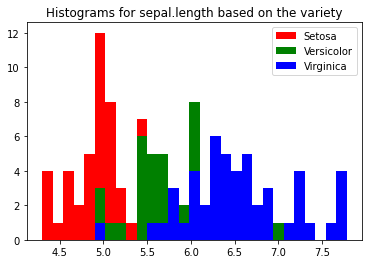

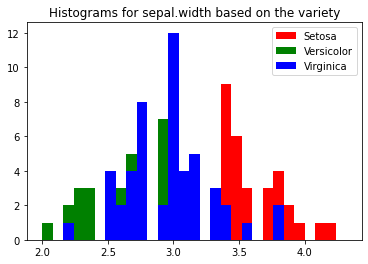

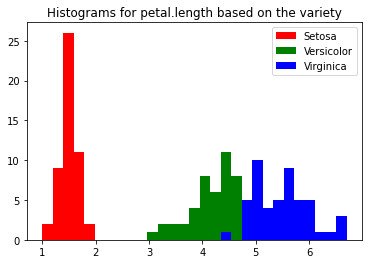

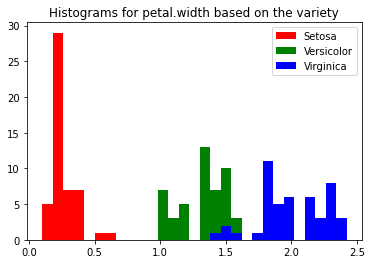

In [8]:
for feat in [col for col in df.columns if col != 'variety']:
  setosa = list(df[df['variety'] == 'Setosa'][feat])
  versicolor = list(df[df['variety'] == 'Versicolor'][feat])
  virginica = list(df[df['variety'] == 'Virginica'][feat])
  xmin = min(min(setosa), min(versicolor), min(virginica))
  xmax = max(max(setosa), max(versicolor), max(virginica))
  width = (xmax - xmin) / 30
  plt.hist(setosa, color='r', density=False, bins=np.arange(xmin, xmax, width))
  plt.hist(versicolor, color='g', density=False, bins=np.arange(xmin, xmax, width))
  plt.hist(virginica, color='b', density=False, bins=np.arange(xmin, xmax, width))
  plt.legend(['Setosa', 'Versicolor', 'Virginica'])
  plt.title(f"Histograms for {feat} based on the variety")
  plt.show()

From these overlaid histograms, it is clear that the features, especially the **petal lengths & widths** will be contributing factors to the target class prediction. 

In [9]:
df.corr()

,sepal.length,sepal.width,petal.length,petal.width
sepal.length,1.000000,-0.117570,0.871754,0.817941
sepal.width,-0.117570,1.000000,-0.428440,-0.366126
petal.length,0.871754,-0.428440,1.000000,0.962865
petal.width,0.817941,-0.366126,0.962865,1.000000


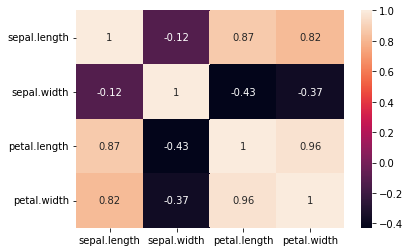

In [10]:
sns.heatmap(df.corr(), annot=True)

It seems like the following feature pairs are highly correlated: 

*   sepal length & petal length
*   sepal length & petal width
*   petal length & petal width





#### Splitting and preparing data for modeling

In [11]:
X = df.drop('variety', axis=1)
y = df['variety'].map({'Setosa': 0, 'Versicolor': 1,  'Virginica': 2}) # converting the target class into numerical type
y.value_counts()

0    50
1    50
2    50
Name: variety, dtype: int64

In [12]:
# 60-20-20 split
X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(X, y, train_size=0.6, random_state=17, stratify=y)
X_test_60, X_val_60, y_test_60, y_val_60 = train_test_split(X_test_60, y_test_60, test_size=0.5, random_state=17, stratify=y_test_60)

print("Value counts after 60-20-20 split")
print("Train")
print(y_train_60.value_counts())
print("Test")
print(y_test_60.value_counts())
print("Validation")
print(y_val_60.value_counts())

print()

# 80-10-10 split
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X, y, train_size=0.8, random_state=17, stratify=y)
X_test_80, X_val_80, y_test_80, y_val_80 = train_test_split(X_test_80, y_test_80, test_size=0.5, random_state=17, stratify=y_test_80)

print("Value counts after 80-10-10 split")
print("Train")
print(y_train_80.value_counts())
print("Test")
print(y_test_80.value_counts())
print("Validation")
print(y_val_80.value_counts())

Value counts after 60-20-20 split
Train
1    30
2    30
0    30
Name: variety, dtype: int64
Test
2    10
0    10
1    10
Name: variety, dtype: int64
Validation
1    10
2    10
0    10
Name: variety, dtype: int64

Value counts after 80-10-10 split
Train
1    40
2    40
0    40
Name: variety, dtype: int64
Test
1    5
0    5
2    5
Name: variety, dtype: int64
Validation
0    5
2    5
1    5
Name: variety, dtype: int64


Since the argument *stratify = label_column* was passed within the *train_test_split* functions, the resulting split data also contains the same ratio of classes (1:1:1)

In [13]:
# funtion to print the results from a cross validation
def print_cv_results(results):
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) with {params}')
    print(f'\nBEST PARAMS: {results.best_params_}\n')

#### SVM

In [14]:
from sklearn.svm import SVC

In [15]:
for X_train, y_train, train_size in zip([X_train_60, X_train_80], [y_train_60, y_train_80], [60, 80]):
  
  print(f"\nSplit ratio: {train_size}:{int((100-train_size)/2)}:{int((100-train_size)/2)}")

  svc = SVC()
  parameters = {
      'kernel': ['linear', 'rbf'],
      'C': [0.1, 1, 10]
  }

  cv = GridSearchCV(svc, parameters, cv=5)
  cv.fit(X_train, y_train.values.ravel())

  print_cv_results(cv)

  joblib.dump(cv.best_estimator_, f'SVM_model_{train_size}.pkl')


Split ratio: 60:20:20
0.956 (+/-0.109) with {'C': 0.1, 'kernel': 'linear'}
0.922 (+/-0.166) with {'C': 0.1, 'kernel': 'rbf'}
0.978 (+/-0.054) with {'C': 1, 'kernel': 'linear'}
0.944 (+/-0.141) with {'C': 1, 'kernel': 'rbf'}
0.967 (+/-0.054) with {'C': 10, 'kernel': 'linear'}
0.978 (+/-0.054) with {'C': 10, 'kernel': 'rbf'}

BEST PARAMS: {'C': 1, 'kernel': 'linear'}


Split ratio: 80:10:10
0.942 (+/-0.085) with {'C': 0.1, 'kernel': 'linear'}
0.925 (+/-0.111) with {'C': 0.1, 'kernel': 'rbf'}
0.975 (+/-0.067) with {'C': 1, 'kernel': 'linear'}
0.95 (+/-0.062) with {'C': 1, 'kernel': 'rbf'}
0.967 (+/-0.062) with {'C': 10, 'kernel': 'linear'}
0.967 (+/-0.097) with {'C': 10, 'kernel': 'rbf'}

BEST PARAMS: {'C': 1, 'kernel': 'linear'}



#### RF

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
for X_train, y_train, train_size in zip([X_train_60, X_train_80], [y_train_60, y_train_80], [60, 80]):
  
  print(f"\nSplit ratio: {train_size}:{int((100-train_size)/2)}:{int((100-train_size)/2)}")

  rf = RandomForestClassifier()
  parameters = {
      'n_estimators': [5, 50, 250],
      'max_depth': [2, 4, 8, 16, 32, None]
  }

  cv = GridSearchCV(rf, parameters, cv=5)
  cv.fit(X_train, y_train.values.ravel())

  print_cv_results(cv)

  joblib.dump(cv.best_estimator_, f'RF_model_{train_size}.pkl')


Split ratio: 60:20:20
0.967 (+/-0.089) with {'max_depth': 2, 'n_estimators': 5}
0.956 (+/-0.083) with {'max_depth': 2, 'n_estimators': 50}
0.944 (+/-0.099) with {'max_depth': 2, 'n_estimators': 250}
0.956 (+/-0.083) with {'max_depth': 4, 'n_estimators': 5}
0.944 (+/-0.099) with {'max_depth': 4, 'n_estimators': 50}
0.944 (+/-0.099) with {'max_depth': 4, 'n_estimators': 250}
0.956 (+/-0.083) with {'max_depth': 8, 'n_estimators': 5}
0.944 (+/-0.099) with {'max_depth': 8, 'n_estimators': 50}
0.944 (+/-0.099) with {'max_depth': 8, 'n_estimators': 250}
0.944 (+/-0.122) with {'max_depth': 16, 'n_estimators': 5}
0.944 (+/-0.099) with {'max_depth': 16, 'n_estimators': 50}
0.944 (+/-0.099) with {'max_depth': 16, 'n_estimators': 250}
0.922 (+/-0.089) with {'max_depth': 32, 'n_estimators': 5}
0.956 (+/-0.083) with {'max_depth': 32, 'n_estimators': 50}
0.944 (+/-0.099) with {'max_depth': 32, 'n_estimators': 250}
0.944 (+/-0.099) with {'max_depth': None, 'n_estimators': 5}
0.944 (+/-0.099) with {'m

#### GB

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
for X_train, y_train, train_size in zip([X_train_60, X_train_80], [y_train_60, y_train_80], [60, 80]):
  
  print(f"\nSplit ratio: {train_size}:{int((100-train_size)/2)}:{int((100-train_size)/2)}")

  gb = GradientBoostingClassifier()
  parameters = {
      'n_estimators': [5, 50, 250, 500],
      'max_depth': [1, 3, 5, 7, 9],
      'learning_rate': [0.01, 0.1, 1, 10, 100]
  }

  cv = GridSearchCV(gb, parameters, cv=5)
  cv.fit(X_train, y_train.values.ravel())

  print_cv_results(cv)

  joblib.dump(cv.best_estimator_, f'GB_model_{train_size}.pkl')


Split ratio: 60:20:20
0.956 (+/-0.083) with {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.956 (+/-0.083) with {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.956 (+/-0.083) with {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 250}
0.956 (+/-0.083) with {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}
0.944 (+/-0.099) with {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.944 (+/-0.099) with {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.944 (+/-0.099) with {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.944 (+/-0.099) with {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.944 (+/-0.099) with {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.944 (+/-0.099) with {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.944 (+/-0.099) with {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250}
0.944 (+/-0.099) with {'learning_rate': 0.01, 'max_depth': 5, 'n_estimato

### Model Comparison

In [20]:
models = dict()
for alg in ['SVM', 'RF', 'GB']:
  for train_size in [60, 80]:
    models[f'{alg}_{train_size}'] = joblib.load(f'{alg}_model_{train_size}.pkl')
models

{'SVM_60': SVC(C=1, kernel='linear'),
 'SVM_80': SVC(C=1, kernel='linear'),
 'RF_60': RandomForestClassifier(max_depth=2, n_estimators=5),
 'RF_80': RandomForestClassifier(max_depth=4, n_estimators=5),
 'GB_60': GradientBoostingClassifier(learning_rate=0.01, max_depth=1, n_estimators=5),
 'GB_80': GradientBoostingClassifier(learning_rate=1, max_depth=1, n_estimators=5)}

In [21]:
def evaluate(model_name, model, X_data, y_data):
  alg = model_name.split('_')[0]
  train_size = int(model_name.split('_')[1])
  start_time = time()
  y_pred = model.predict(X_data)
  latency = round((time() - start_time)*1000, 2)
  accuracy = round(accuracy_score(y_data, y_pred), 4)
  precision = round(precision_score(y_data, y_pred, average='macro'), 4)
  recall = round(recall_score(y_data, y_pred, average='macro'), 4)
  print(f"Algorithm: {alg}; Split Ratio: {train_size}:{int((100-train_size)/2)}:{int((100-train_size)/2)}; Accuracy: {accuracy}; Precision: {precision}; Recall: {recall}; Latency: {latency}ms")

In [22]:
# Evaluation on the training data
for model_name, model in models.items():
  if model_name[:-3] == "_60":
    evaluate(model_name, model, X_train_60, y_train_60)
  else:
    evaluate(model_name, model, X_train_80, y_train_80)

Algorithm: SVM; Split Ratio: 60:20:20; Accuracy: 0.975; Precision: 0.9752; Recall: 0.975; Latency: 1.95ms
Algorithm: SVM; Split Ratio: 80:10:10; Accuracy: 0.9917; Precision: 0.9919; Recall: 0.9917; Latency: 5.3ms
Algorithm: RF; Split Ratio: 60:20:20; Accuracy: 0.9583; Precision: 0.96; Recall: 0.9583; Latency: 3.23ms
Algorithm: RF; Split Ratio: 80:10:10; Accuracy: 0.9917; Precision: 0.9919; Recall: 0.9917; Latency: 2.99ms
Algorithm: GB; Split Ratio: 60:20:20; Accuracy: 0.9583; Precision: 0.96; Recall: 0.9583; Latency: 2.24ms
Algorithm: GB; Split Ratio: 80:10:10; Accuracy: 0.975; Precision: 0.9767; Recall: 0.975; Latency: 1.95ms


In [23]:
# Evaluation on the validation data
for model_name, model in models.items():
  if model_name[:-3] == "_60":
    evaluate(model_name, model, X_val_60, y_val_60)
  else:
    evaluate(model_name, model, X_val_80, y_val_80)

Algorithm: SVM; Split Ratio: 60:20:20; Accuracy: 0.9333; Precision: 0.9444; Recall: 0.9333; Latency: 1.97ms
Algorithm: SVM; Split Ratio: 80:10:10; Accuracy: 0.9333; Precision: 0.9444; Recall: 0.9333; Latency: 4.48ms
Algorithm: RF; Split Ratio: 60:20:20; Accuracy: 0.9333; Precision: 0.9444; Recall: 0.9333; Latency: 3.11ms
Algorithm: RF; Split Ratio: 80:10:10; Accuracy: 0.9333; Precision: 0.9444; Recall: 0.9333; Latency: 2.9ms
Algorithm: GB; Split Ratio: 60:20:20; Accuracy: 0.8667; Precision: 0.9048; Recall: 0.8667; Latency: 1.96ms
Algorithm: GB; Split Ratio: 80:10:10; Accuracy: 0.9333; Precision: 0.9444; Recall: 0.9333; Latency: 1.89ms


**Inferences from the predictions on the validation set:**

1. SVM has almost the same performance on both the split ratios in terms of performance metrics. Latency was slightly better for the 80-10-10 split.
2. Random Forest model trained on 80-10-10 split data has a comparitively higher performance metrics. Also, the latency is much smaller than the other split.
3. Gradient Boosting also displayed much better performance metrics while using the 80-10-10 split data.
4. Among the three types of algorithms, all three trained on the 80-10-10 split data have similar classification power. Latency is the only determining factor here. Of the three, 80-10-10 split data trained algorithms, gradient boosting has the best latency. (At least slightly)



In [24]:
# Evaluation on the test data
for model_name, model in models.items():
  if model_name[:-3] == "_60":
    evaluate(model_name, model, X_test_60, y_test_60)
  else:
    evaluate(model_name, model, X_test_80, y_test_80)

Algorithm: SVM; Split Ratio: 60:20:20; Accuracy: 1.0; Precision: 1.0; Recall: 1.0; Latency: 2.42ms
Algorithm: SVM; Split Ratio: 80:10:10; Accuracy: 1.0; Precision: 1.0; Recall: 1.0; Latency: 3.15ms
Algorithm: RF; Split Ratio: 60:20:20; Accuracy: 1.0; Precision: 1.0; Recall: 1.0; Latency: 3.04ms
Algorithm: RF; Split Ratio: 80:10:10; Accuracy: 1.0; Precision: 1.0; Recall: 1.0; Latency: 2.38ms
Algorithm: GB; Split Ratio: 60:20:20; Accuracy: 1.0; Precision: 1.0; Recall: 1.0; Latency: 1.8ms
Algorithm: GB; Split Ratio: 80:10:10; Accuracy: 1.0; Precision: 1.0; Recall: 1.0; Latency: 1.99ms


Inferences similar to that from the validation data are found from the test data as well. Here the latency for SVM is slightly better than the GB. But since the validation data latency difference is better for the GB, we conclude that the Gradient boosting algorithm trained on 80-10-10 split data is the best among these.

#### Conclusion

It was found that for all the three algorithms, the 80-10-10 split data gave better performance. And among the three, Gradient Boosting model is chosen to be the best classifier in terms of precision, recall, f1-score and latency.

The classification report for the best model is as follows.

In [25]:
model = joblib.load('GB_model_80.pkl')
y_pred = model.predict(X_test_80)
classification_report(y_test_80, y_pred)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00         5\n           1       1.00      1.00      1.00         5\n           2       1.00      1.00      1.00         5\n\n    accuracy                           1.00        15\n   macro avg       1.00      1.00      1.00        15\nweighted avg       1.00      1.00      1.00        15\n'